In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import simpy
from LEOEnvironmentRL import initialize, load_route_from_csv  # Use RL version
import pandas as pd
import os
from stable_baselines3 import DQN
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker
import torch
import random

# %% 
import sb3_contrib
from HandoverEnvironment import LEOEnv as LEOEnvPPO 
from HandoverEnvironment import mask_fn, predict_valid_action
from HandoverEnvironment_DQN import LEOEnv as LEOEnvDQN
from HandoverEnvironment_DQN import predict_valid_action as predict_valid_action_dqn
from HandoverEnvironment_ODT import LEOEnv as LEOEnvODT
from HandoverEnvironment_ODT import predict_valid_action_dt
from ODT import OnlineDecisionTransformer
from LEOEnvironment import LEOEnv as LEOEnvBase

['ARS', 'CrossQ', 'MaskablePPO', 'QRDQN', 'RecurrentPPO', 'TQC', 'TRPO', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'ars', 'common', 'crossq', 'file_handler', 'os', 'ppo_mask', 'ppo_recurrent', 'qrdqn', 'tqc', 'trpo', 'version_file']


In [19]:
# Load observations from csv file 
obs_base_list = pd.read_csv('BASELINE_observations.csv').values
obs_dqn_list = pd.read_csv('DQN_observations.csv').values
obs_ppo_list = pd.read_csv('PPO_observations.csv').values
obs_odt_list = pd.read_csv('ODT_observations.csv').values

# Check data types
print("Data type:", type(obs_base_list[0,0]))
print("Sample values:", obs_base_list[0,:3])

Data type: <class 'numpy.float64'>
Sample values: [  0.         -12.84441376   0.13527127]


In [20]:
obs_base_list = np.array(obs_base_list)
obs_dqn_list = np.array(obs_dqn_list)    
obs_ppo_list = np.array(obs_ppo_list)
obs_odt_list = np.array(obs_odt_list)

In [21]:
obs_dqn_list

array([[ 0.00000000e+00, -1.52908154e+01,  1.53564336e-02, ...,
         1.00000000e+00,  1.60293174e+00,  1.00000000e+00],
       [ 1.00000000e+00, -1.28442106e+01,  5.45431197e-01, ...,
         2.00000000e+00,  1.45738190e+02,  1.00000000e+00],
       [ 2.00000000e+00, -1.28682566e+01,  2.31754765e-01, ...,
         3.00000000e+00,  3.18681091e+02,  5.75710654e-01],
       ...,
       [ 1.89000000e+02, -1.33302498e+01,  1.11216977e-01, ...,
         1.89000000e+02,  3.71631719e+04,  6.24907613e-01],
       [ 1.90000000e+02, -1.30253763e+01,  5.31044185e-01, ...,
         1.90000000e+02,  3.73494375e+04,  1.00000000e+00],
       [ 1.91000000e+02, -1.33351421e+01,  5.83256483e-02, ...,
         1.91000000e+02,  3.73839141e+04,  4.14869964e-01]])

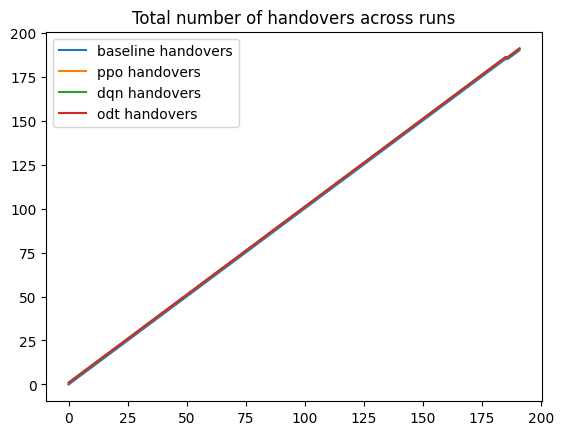

In [24]:
import matplotlib.pyplot as plt
plt.plot(obs_base_list[:, 4], label = 'baseline handovers')
plt.plot(obs_ppo_list[:, 4], label = 'ppo handovers')
plt.plot(obs_dqn_list[:, 4],  label = 'dqn handovers')
plt.plot(obs_odt_list[:, 4], label = 'odt handovers')
plt.legend()
#plt.yticks(np.arange(0, 200, step=10))
plt.title('Total number of handovers across runs')
plt.show()

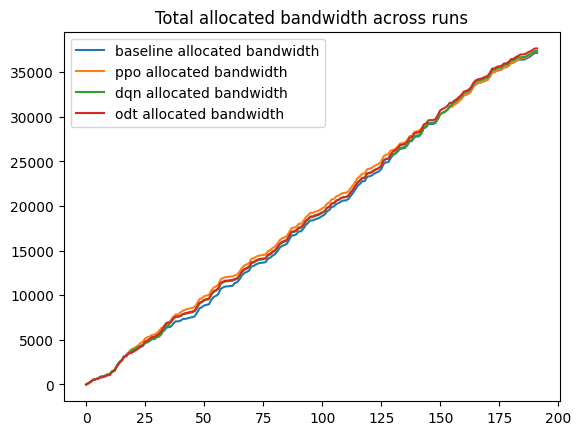

In [25]:
plt.plot(obs_base_list[:, 5], label = 'baseline allocated bandwidth')
plt.plot(obs_ppo_list[:, 5], label = 'ppo allocated bandwidth')
plt.plot(obs_dqn_list[:, 5], label = 'dqn allocated bandwidth')
plt.plot(obs_odt_list[:, 5], label = 'odt allocated bandwidth')
plt.legend()
plt.title('Total allocated bandwidth across runs')
plt.show()

In [27]:
# Get average allocation to demand across runs 
avg_allocated_to_demand_base = []
avg_allocated_to_demand_ppo = []
avg_allocated_to_demand_dqn = []
avg_allocated_to_demand_odt = []

for i in range(len(obs_base_list)): 
    avg_allocated_to_demand_base.append(np.mean(obs_base_list[:i, 6]))
    avg_allocated_to_demand_ppo.append(np.mean(obs_ppo_list[:i, 6]))
    avg_allocated_to_demand_dqn.append(np.mean(obs_dqn_list[:i, 6]))
    avg_allocated_to_demand_odt.append(np.mean(obs_odt_list[:i, 6]))

/Users/hindmukhtar/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hindmukhtar/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


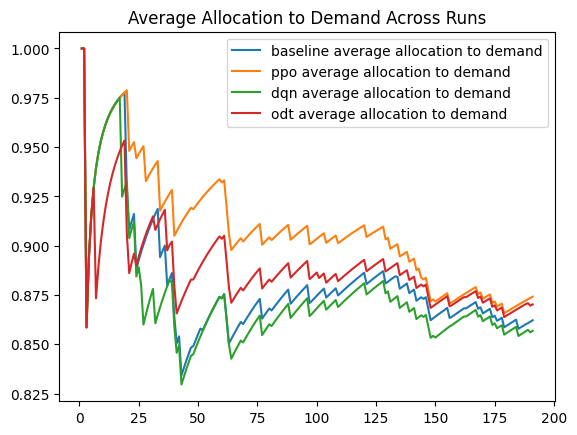

In [28]:
plt.plot(avg_allocated_to_demand_base, label = 'baseline average allocation to demand')
plt.plot(avg_allocated_to_demand_ppo, label = 'ppo average allocation to demand')
plt.plot(avg_allocated_to_demand_dqn, label = 'dqn average allocation to demand')
plt.plot(avg_allocated_to_demand_odt, label = 'odt average allocation to demand')
plt.legend()
plt.title('Average Allocation to Demand Across Runs')
plt.show()

In [30]:
# Get average allocation to demand across runs 
allocated_to_demand_base = []
allocated_to_demand_ppo = []
allocated_to_demand_dqn = []
allocated_to_demand_odt = []

for i in range(len(obs_base_list)): 
    allocated_to_demand_base.append(obs_base_list[i, 6])
    allocated_to_demand_ppo.append(obs_ppo_list[i, 6])
    allocated_to_demand_dqn.append(obs_dqn_list[i, 6])
    allocated_to_demand_odt.append(obs_odt_list[i, 6])

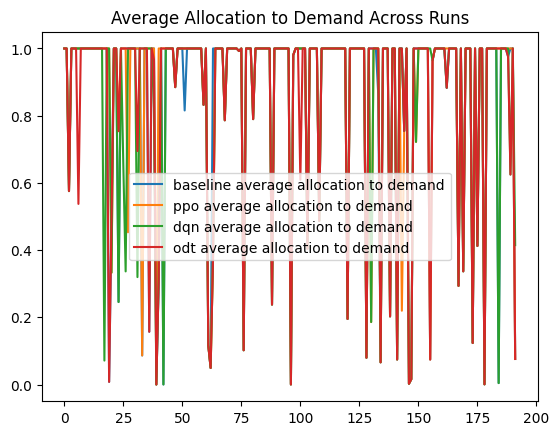

In [31]:
plt.plot(allocated_to_demand_base, label = 'baseline average allocation to demand')
plt.plot(allocated_to_demand_ppo, label = 'ppo average allocation to demand')
plt.plot(allocated_to_demand_dqn, label = 'dqn average allocation to demand')
plt.plot(allocated_to_demand_odt, label = 'odt average allocation to demand')
plt.legend()
plt.title('Average Allocation to Demand Across Runs')
plt.show()